In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

In [2]:
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-3

In [3]:
import numpy as np
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from datasets import load_dataset
dataset = load_dataset('Maysee/tiny-imagenet')

from sklearn.model_selection import train_test_split
train_cover, train_secret = train_test_split(dataset['train']['image'][:15000], train_size=0.5, shuffle=True)
test_cover, test_secret = train_test_split(dataset['valid']['image'][:1000], train_size=0.5, shuffle=True)

del dataset

/home/studio-lab-user/.conda/envs/tensorflow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset parquet (/home/studio-lab-user/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 2/2 [00:00<00:00, 14.40it/s]


In [5]:
STEPS = len(train_cover) // BATCH_SIZE + 1
TEST_STEPS = len(test_cover) // BATCH_SIZE + 1

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ([np.asarray(x.convert('RGB')) for x in train_cover], 
     [np.asarray(x.convert('RGB')) for x in train_secret])
)

del train_cover
del train_secret

In [7]:
train_dataset = train_dataset.shuffle(64).batch(BATCH_SIZE)

In [8]:
test_dataset = tf.data.Dataset.from_tensor_slices(
    ([np.asarray(x.convert('RGB')) for x in test_cover],
     [np.asarray(x.convert('RGB')) for x in test_secret])
)

del test_cover
del test_secret

In [9]:
test_dataset = test_dataset.batch(BATCH_SIZE)

In [10]:
@tf.function
def conv2d(input, filters, biases, strides=1):
    x = tf.nn.conv2d(input, filters, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, biases)
    return tf.nn.relu(x)

In [11]:
initializer = tf.initializers.glorot_normal(12541)

In [12]:
WEIGHTS_PREP_NETWORK = {
    'conv3x3_1': tf.Variable(initializer([3, 3, 3, 50])),
    'conv3x3_2': tf.Variable(initializer([3, 3, 50, 50])),
    'conv3x3_3': tf.Variable(initializer([3, 3, 50, 50])),
    'conv3x3_4': tf.Variable(initializer([3, 3, 50, 50])),

    'conv4x4_1': tf.Variable(initializer([4, 4, 3, 50])),
    'conv4x4_2': tf.Variable(initializer([4, 4, 50, 50])),
    'conv4x4_3': tf.Variable(initializer([4, 4, 50, 50])),
    'conv4x4_4': tf.Variable(initializer([4, 4, 50, 50])),

    'conv5x5_1': tf.Variable(initializer([5, 5, 3, 50])),
    'conv5x5_2': tf.Variable(initializer([5, 5, 50, 50])),
    'conv5x5_3': tf.Variable(initializer([5, 5, 50, 50])),
    'conv5x5_4': tf.Variable(initializer([5, 5, 50, 50])),

    'conv3x3_5': tf.Variable(initializer([3, 3, 150, 50])),
    'conv4x4_5': tf.Variable(initializer([4, 4, 150, 50])),
    'conv5x5_5': tf.Variable(initializer([5, 5, 150, 50]))
}

BIASES_PREP_NETWORK = {
    'conv3x3_1': tf.Variable(tf.zeros([50])),
    'conv3x3_2': tf.Variable(tf.zeros([50])),
    'conv3x3_3': tf.Variable(tf.zeros([50])),
    'conv3x3_4': tf.Variable(tf.zeros([50])),

    'conv4x4_1': tf.Variable(tf.zeros([50])),
    'conv4x4_2': tf.Variable(tf.zeros([50])),
    'conv4x4_3': tf.Variable(tf.zeros([50])),
    'conv4x4_4': tf.Variable(tf.zeros([50])),

    'conv5x5_1': tf.Variable(tf.zeros([50])),
    'conv5x5_2': tf.Variable(tf.zeros([50])),
    'conv5x5_3': tf.Variable(tf.zeros([50])),
    'conv5x5_4': tf.Variable(tf.zeros([50])),


    'conv3x3_5': tf.Variable(tf.zeros([50])),
    'conv4x4_5': tf.Variable(tf.zeros([50])),
    'conv5x5_5': tf.Variable(tf.zeros([50]))
}

In [13]:
@tf.function
def prep_network(secret_tensor):

    secret_tensor = tf.reshape(secret_tensor, [-1, 64, 64, 3])
    secret_tensor = tf.cast(secret_tensor, tf.float32)
    secret_tensor = tf.math.divide(secret_tensor, 255.)

    with tf.name_scope('prep_network'):
        with tf.name_scope('conv3x3'):
            conv3x3 = secret_tensor
            conv3x3 = conv2d(conv3x3, WEIGHTS_PREP_NETWORK['conv3x3_1'], BIASES_PREP_NETWORK['conv3x3_1'])
            conv3x3 = conv2d(conv3x3, WEIGHTS_PREP_NETWORK['conv3x3_2'], BIASES_PREP_NETWORK['conv3x3_2'])
            conv3x3 = conv2d(conv3x3, WEIGHTS_PREP_NETWORK['conv3x3_3'], BIASES_PREP_NETWORK['conv3x3_3'])
            conv3x3 = conv2d(conv3x3, WEIGHTS_PREP_NETWORK['conv3x3_4'], BIASES_PREP_NETWORK['conv3x3_4'])

        with tf.name_scope('conv4x4'):
            conv4x4 = secret_tensor
            conv4x4 = conv2d(conv4x4, WEIGHTS_PREP_NETWORK['conv4x4_1'], BIASES_PREP_NETWORK['conv4x4_1'])
            conv4x4 = conv2d(conv4x4, WEIGHTS_PREP_NETWORK['conv4x4_2'], BIASES_PREP_NETWORK['conv4x4_2'])
            conv4x4 = conv2d(conv4x4, WEIGHTS_PREP_NETWORK['conv4x4_3'], BIASES_PREP_NETWORK['conv4x4_3'])
            conv4x4 = conv2d(conv4x4, WEIGHTS_PREP_NETWORK['conv4x4_4'], BIASES_PREP_NETWORK['conv4x4_4'])

        with tf.name_scope('conv5x5'):
            conv5x5 = secret_tensor
            conv5x5 = conv2d(conv5x5, WEIGHTS_PREP_NETWORK['conv5x5_1'], BIASES_PREP_NETWORK['conv5x5_1'])
            conv5x5 = conv2d(conv5x5, WEIGHTS_PREP_NETWORK['conv5x5_2'], BIASES_PREP_NETWORK['conv5x5_2'])
            conv5x5 = conv2d(conv5x5, WEIGHTS_PREP_NETWORK['conv5x5_3'], BIASES_PREP_NETWORK['conv5x5_3'])
            conv5x5 = conv2d(conv5x5, WEIGHTS_PREP_NETWORK['conv5x5_4'], BIASES_PREP_NETWORK['conv5x5_4'])

        concat_1 = tf.concat([conv3x3, conv4x4, conv5x5], axis=3)

        conv3x3 = conv2d(concat_1, WEIGHTS_PREP_NETWORK['conv3x3_5'], BIASES_PREP_NETWORK['conv3x3_5'])
        conv4x4 = conv2d(concat_1, WEIGHTS_PREP_NETWORK['conv4x4_5'], BIASES_PREP_NETWORK['conv4x4_5'])
        conv5x5 = conv2d(concat_1, WEIGHTS_PREP_NETWORK['conv5x5_5'], BIASES_PREP_NETWORK['conv5x5_5'])

        return tf.concat([conv3x3, conv4x4, conv5x5], axis=3)

In [14]:
WEIGHTS_HIDE_NETWORK = {
    'conv3x3_1': tf.Variable(initializer([3, 3, 153, 50])),
    'conv3x3_2': tf.Variable(initializer([3, 3, 50, 50])),
    'conv3x3_3': tf.Variable(initializer([3, 3, 50, 50])),
    'conv3x3_4': tf.Variable(initializer([3, 3, 50, 50])),

    'conv4x4_1': tf.Variable(initializer([4, 4, 153, 50])),
    'conv4x4_2': tf.Variable(initializer([4, 4, 50, 50])),
    'conv4x4_3': tf.Variable(initializer([4, 4, 50, 50])),
    'conv4x4_4': tf.Variable(initializer([4, 4, 50, 50])),

    'conv5x5_1': tf.Variable(initializer([5, 5, 153, 50])),
    'conv5x5_2': tf.Variable(initializer([5, 5, 50, 50])),
    'conv5x5_3': tf.Variable(initializer([5, 5, 50, 50])),
    'conv5x5_4': tf.Variable(initializer([5, 5, 50, 50])),

    'conv3x3_5': tf.Variable(initializer([3, 3, 150, 50])),
    'conv4x4_5': tf.Variable(initializer([4, 4, 150, 50])),
    'conv5x5_5': tf.Variable(initializer([5, 5, 150, 50])),

    'out': tf.Variable(initializer([1, 1, 150, 3])),
}

BIASES_HIDE_NETWORK = {
    'conv3x3_1': tf.Variable(tf.zeros([50])),
    'conv3x3_2': tf.Variable(tf.zeros([50])),
    'conv3x3_3': tf.Variable(tf.zeros([50])),
    'conv3x3_4': tf.Variable(tf.zeros([50])),

    'conv4x4_1': tf.Variable(tf.zeros([50])),
    'conv4x4_2': tf.Variable(tf.zeros([50])),
    'conv4x4_3': tf.Variable(tf.zeros([50])),
    'conv4x4_4': tf.Variable(tf.zeros([50])),

    'conv5x5_1': tf.Variable(tf.zeros([50])),
    'conv5x5_2': tf.Variable(tf.zeros([50])),
    'conv5x5_3': tf.Variable(tf.zeros([50])),
    'conv5x5_4': tf.Variable(tf.zeros([50])),


    'conv3x3_5': tf.Variable(tf.zeros([50])),
    'conv4x4_5': tf.Variable(tf.zeros([50])),
    'conv5x5_5': tf.Variable(tf.zeros([50])),

    'out': tf.Variable(tf.zeros([3]))
}


In [15]:
@tf.function
def hide_network(cover_tensor, prep_tensor):

    cover_tensor = tf.reshape(cover_tensor, [-1, 64, 64, 3])
    cover_tensor = tf.cast(cover_tensor, tf.float32)
    cover_tensor = tf.math.divide(cover_tensor, 255.)

    with tf.name_scope('hide_network'):
        concat_1 = tf.concat([cover_tensor, prep_tensor], axis=3)

        with tf.name_scope('conv3x3'):
            conv3x3 = concat_1
            conv3x3 = conv2d(conv3x3, WEIGHTS_HIDE_NETWORK['conv3x3_1'], BIASES_HIDE_NETWORK['conv3x3_1'])
            conv3x3 = conv2d(conv3x3, WEIGHTS_HIDE_NETWORK['conv3x3_2'], BIASES_HIDE_NETWORK['conv3x3_2'])
            conv3x3 = conv2d(conv3x3, WEIGHTS_HIDE_NETWORK['conv3x3_3'], BIASES_HIDE_NETWORK['conv3x3_3'])
            conv3x3 = conv2d(conv3x3, WEIGHTS_HIDE_NETWORK['conv3x3_4'], BIASES_HIDE_NETWORK['conv3x3_4'])

        with tf.name_scope('conv4x4'):
            conv4x4 = concat_1
            conv4x4 = conv2d(conv4x4, WEIGHTS_HIDE_NETWORK['conv4x4_1'], BIASES_HIDE_NETWORK['conv4x4_1'])
            conv4x4 = conv2d(conv4x4, WEIGHTS_HIDE_NETWORK['conv4x4_2'], BIASES_HIDE_NETWORK['conv4x4_2'])
            conv4x4 = conv2d(conv4x4, WEIGHTS_HIDE_NETWORK['conv4x4_3'], BIASES_HIDE_NETWORK['conv4x4_3'])
            conv4x4 = conv2d(conv4x4, WEIGHTS_HIDE_NETWORK['conv4x4_4'], BIASES_HIDE_NETWORK['conv4x4_4'])

        with tf.name_scope('conv5x5'):
            conv5x5 = concat_1
            conv5x5 = conv2d(conv5x5, WEIGHTS_HIDE_NETWORK['conv5x5_1'], BIASES_HIDE_NETWORK['conv5x5_1'])
            conv5x5 = conv2d(conv5x5, WEIGHTS_HIDE_NETWORK['conv5x5_2'], BIASES_HIDE_NETWORK['conv5x5_2'])
            conv5x5 = conv2d(conv5x5, WEIGHTS_HIDE_NETWORK['conv5x5_3'], BIASES_HIDE_NETWORK['conv5x5_3'])
            conv5x5 = conv2d(conv5x5, WEIGHTS_HIDE_NETWORK['conv5x5_4'], BIASES_HIDE_NETWORK['conv5x5_4'])

        concat_2 = tf.concat([conv3x3, conv4x4, conv5x5], axis=3)

        conv3x3 = conv2d(concat_2, WEIGHTS_HIDE_NETWORK['conv3x3_5'], BIASES_HIDE_NETWORK['conv3x3_5'])
        conv4x4 = conv2d(concat_2, WEIGHTS_HIDE_NETWORK['conv4x4_5'], BIASES_HIDE_NETWORK['conv4x4_5'])
        conv5x5 = conv2d(concat_2, WEIGHTS_HIDE_NETWORK['conv5x5_5'], BIASES_HIDE_NETWORK['conv5x5_5'])

        concat_final = tf.concat([conv3x3, conv4x4, conv5x5], axis=3)

        return conv2d(concat_final, WEIGHTS_HIDE_NETWORK['out'], BIASES_HIDE_NETWORK['out'])

In [16]:
WEIGHTS_REVEAL_NETWORK = {
    'conv3x3_1': tf.Variable(initializer([3, 3, 3, 50])),
    'conv3x3_2': tf.Variable(initializer([3, 3, 50, 50])),
    'conv3x3_3': tf.Variable(initializer([3, 3, 50, 50])),
    'conv3x3_4': tf.Variable(initializer([3, 3, 50, 50])),

    'conv4x4_1': tf.Variable(initializer([4, 4, 3, 50])),
    'conv4x4_2': tf.Variable(initializer([4, 4, 50, 50])),
    'conv4x4_3': tf.Variable(initializer([4, 4, 50, 50])),
    'conv4x4_4': tf.Variable(initializer([4, 4, 50, 50])),

    'conv5x5_1': tf.Variable(initializer([5, 5, 3, 50])),
    'conv5x5_2': tf.Variable(initializer([5, 5, 50, 50])),
    'conv5x5_3': tf.Variable(initializer([5, 5, 50, 50])),
    'conv5x5_4': tf.Variable(initializer([5, 5, 50, 50])),

    'conv3x3_5': tf.Variable(initializer([3, 3, 150, 50])),
    'conv4x4_5': tf.Variable(initializer([4, 4, 150, 50])),
    'conv5x5_5': tf.Variable(initializer([5, 5, 150, 50])),

    'out': tf.Variable(initializer([1, 1, 150, 3])),
}

BIASES_REVEAL_NETWORK = {
    'conv3x3_1': tf.Variable(tf.zeros([50])),
    'conv3x3_2': tf.Variable(tf.zeros([50])),
    'conv3x3_3': tf.Variable(tf.zeros([50])),
    'conv3x3_4': tf.Variable(tf.zeros([50])),

    'conv4x4_1': tf.Variable(tf.zeros([50])),
    'conv4x4_2': tf.Variable(tf.zeros([50])),
    'conv4x4_3': tf.Variable(tf.zeros([50])),
    'conv4x4_4': tf.Variable(tf.zeros([50])),

    'conv5x5_1': tf.Variable(tf.zeros([50])),
    'conv5x5_2': tf.Variable(tf.zeros([50])),
    'conv5x5_3': tf.Variable(tf.zeros([50])),
    'conv5x5_4': tf.Variable(tf.zeros([50])),


    'conv3x3_5': tf.Variable(tf.zeros([50])),
    'conv4x4_5': tf.Variable(tf.zeros([50])),
    'conv5x5_5': tf.Variable(tf.zeros([50])),

    'out': tf.Variable(tf.zeros([3]))
}

In [17]:
@tf.function
def reveal_network(hide_tensor):

    hide_tensor = tf.reshape(hide_tensor, [-1, 64, 64, 3])
    hide_tensor = tf.cast(hide_tensor, tf.float32)
    hide_tensor = tf.math.divide(hide_tensor, 255.)

    with tf.name_scope('reveal_network'):
        with tf.name_scope('conv3x3'):
            conv3x3 = hide_tensor
            conv3x3 = conv2d(conv3x3, WEIGHTS_REVEAL_NETWORK['conv3x3_1'], BIASES_REVEAL_NETWORK['conv3x3_1'])
            conv3x3 = conv2d(conv3x3, WEIGHTS_REVEAL_NETWORK['conv3x3_2'], BIASES_REVEAL_NETWORK['conv3x3_2'])
            conv3x3 = conv2d(conv3x3, WEIGHTS_REVEAL_NETWORK['conv3x3_3'], BIASES_REVEAL_NETWORK['conv3x3_3'])
            conv3x3 = conv2d(conv3x3, WEIGHTS_REVEAL_NETWORK['conv3x3_4'], BIASES_REVEAL_NETWORK['conv3x3_4'])

        with tf.name_scope('conv4x4'):
            conv4x4 = hide_tensor
            conv4x4 = conv2d(conv4x4, WEIGHTS_REVEAL_NETWORK['conv4x4_1'], BIASES_REVEAL_NETWORK['conv4x4_1'])
            conv4x4 = conv2d(conv4x4, WEIGHTS_REVEAL_NETWORK['conv4x4_2'], BIASES_REVEAL_NETWORK['conv4x4_2'])
            conv4x4 = conv2d(conv4x4, WEIGHTS_REVEAL_NETWORK['conv4x4_3'], BIASES_REVEAL_NETWORK['conv4x4_3'])
            conv4x4 = conv2d(conv4x4, WEIGHTS_REVEAL_NETWORK['conv4x4_4'], BIASES_REVEAL_NETWORK['conv4x4_4'])

        with tf.name_scope('conv5x5'):
            conv5x5 = hide_tensor
            conv5x5 = conv2d(conv5x5, WEIGHTS_REVEAL_NETWORK['conv5x5_1'], BIASES_REVEAL_NETWORK['conv5x5_1'])
            conv5x5 = conv2d(conv5x5, WEIGHTS_REVEAL_NETWORK['conv5x5_2'], BIASES_REVEAL_NETWORK['conv5x5_2'])
            conv5x5 = conv2d(conv5x5, WEIGHTS_REVEAL_NETWORK['conv5x5_3'], BIASES_REVEAL_NETWORK['conv5x5_3'])
            conv5x5 = conv2d(conv5x5, WEIGHTS_REVEAL_NETWORK['conv5x5_4'], BIASES_REVEAL_NETWORK['conv5x5_4'])

        concat_1 = tf.concat([conv3x3, conv4x4, conv5x5], axis=3)

        conv3x3 = conv2d(concat_1, WEIGHTS_REVEAL_NETWORK['conv3x3_5'], BIASES_REVEAL_NETWORK['conv3x3_5'])
        conv4x4 = conv2d(concat_1, WEIGHTS_REVEAL_NETWORK['conv4x4_5'], BIASES_REVEAL_NETWORK['conv4x4_5'])
        conv5x5 = conv2d(concat_1, WEIGHTS_REVEAL_NETWORK['conv5x5_5'], BIASES_REVEAL_NETWORK['conv5x5_5'])

        concat_final = tf.concat([conv3x3, conv4x4, conv5x5], axis=3)

        return conv2d(concat_final, WEIGHTS_REVEAL_NETWORK['out'], BIASES_REVEAL_NETWORK['out'])

In [18]:
@tf.function
def steganorgraphy_loss(cover_input, secret_input, cover_output, secret_output, beta=1.0):
    beta = tf.constant(beta, name="beta")

    cover_mse = tf.losses.mean_squared_error(cover_input, cover_output)
    secret_mse = tf.losses.mean_squared_error(secret_input, secret_output)

    total_loss = cover_mse + beta * secret_mse

    return total_loss, cover_mse, secret_mse

In [19]:
optimizer = tf.optimizers.Adam(LEARNING_RATE)

In [20]:
from IPython.display import clear_output

for epoch in range(EPOCHS):
    for step, (cover, secret) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            prep_output = prep_network(secret)
            hide_output = hide_network(cover, prep_output)
            reveal_output = reveal_network(hide_output)
            total_loss, cover_loss, secret_loss = steganorgraphy_loss(cover, secret, hide_output, reveal_output)

        trainable_variables = list(WEIGHTS_PREP_NETWORK.values()) + \
            list(WEIGHTS_HIDE_NETWORK.values()) + \
            list(WEIGHTS_REVEAL_NETWORK.values()) + \
            list(BIASES_PREP_NETWORK.values()) + \
            list(BIASES_HIDE_NETWORK.values()) + \
            list(BIASES_REVEAL_NETWORK.values())

        grads = tape.gradient(total_loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))

        if (step % 10 == 0) or (step == STEPS - 1 == 0):
            clear_output()
            print(
                "Epoch %d/%d:\n Step %d/%d:\n  Cover loss: %.4f\n  Secret loss %.4f\n  Total loss: %.4f."
                % (epoch + 1, EPOCHS, step + 1, STEPS, np.mean(cover_loss), np.mean(secret_loss), np.mean(total_loss))
            )

            print("Seen so far: %s samples" % ((step + 1) * BATCH_SIZE))

Epoch 100/100:
 Step 231/235:
  Cover loss: 111.5485
  Secret loss 56.5240
  Total loss: 168.0725.
Seen so far: 7392 samples


In [21]:
import PIL

In [24]:
loss_mean = list()

for step, (cover, secret) in enumerate(test_dataset):
    prep_output = prep_network(secret)
    hide_output = hide_network(cover, prep_output)
    reveal_output = reveal_network(hide_output)
    total_loss, cover_loss, secret_loss = steganorgraphy_loss(cover, secret, hide_output, reveal_output)

    for loss in total_loss:
        loss_mean.append(loss)

    clear_output()
    print("Total loss: %.4f" % (np.mean(loss_mean)))

Total loss: 160.3530


Cover image:


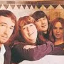

Secret image:


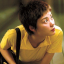

Cover with secret:


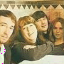

Secret revealed:


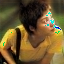

In [39]:
print("Cover image:")
cover = PIL.Image.open("./example/imgs/cover.png").convert('RGB')
cover.show()

print("Secret image:")
secret = PIL.Image.open("./example/imgs/secret.png").convert('RGB')
secret.show()

# Hidding revealing the secret
prep_output = prep_network(np.array(secret))
hide_output = hide_network(np.array(cover), prep_output)
reveal_output = reveal_network(hide_output)

print("Cover with secret:")
PIL.Image.fromarray(
  np.array(hide_output[0], dtype=np.uint8), 'RGB'
).show()

print("Secret revealed:")
PIL.Image.fromarray(
  np.array(reveal_output[0], dtype=np.uint8), 'RGB'
).show()